Устанавливаем пакеты для доступа к Гуглодиску, настраиваем параметры доступа.

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Импорт необходимых библиотек

In [0]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score


import tensorflow as tf
tf.set_random_seed(1)

import io
from google.colab import files

Читаем файлы с гуглодиска. Действие это запутанное - нужно сначала выяснить идентификатор файла, и лишь потом получим доступ.
Файлы я экспортирую в каталог на гуглодиске, идентификатор этого каталога = "0B8Vss7j4W1caazg0OFp6MzFDOFk". Прочитаем все файлы внутри каталога, выедем на экран их id, затем выберем нужный.

In [3]:
# Auto-iterate through all files in the '0B8Vss7j4W1caazg0OFp6MzFDOFk' folder.
file_list = drive.ListFile({'q': "'0B8Vss7j4W1caazg0OFp6MzFDOFk' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s, fileSize: %s Kb' % (file1['title'], file1['id'], float(file1['fileSize'])//1024))

title: train_sample.csv, id: 1PTUjFVOcneRJTcp6mfPkPKGA4HPCoQnv, fileSize: 7329.0 Kb
title: test_sample.csv, id: 1N-DedUh7bmY7-RGrPCB-SYO844vLasUX, fileSize: 1273.0 Kb
title: small_sample.csv, id: 1eboZeUIrHlaSQkxjBiyclu1ggwUI6Vzf, fileSize: 0.0 Kb
title: test_sample90.csv, id: 1FFaJG9Re9kGhOXsoxO0W5A8wEXXF13EP, fileSize: 3438.0 Kb
title: train_sample90m.csv, id: 1Yqsl4UIb7H2GtJnUMWkesw7gHqEBJvHA, fileSize: 8720.0 Kb
title: small_sample_30polys.csv, id: 13TygCeoAsDSEmhDSGuwApaMuRaau42ig, fileSize: 2436.0 Kb
title: change_sample_14_seed1.csv, id: 1P4RwP6PFbG9V-600VqQPGTo1PmM5Kp-k, fileSize: 110.0 Kb
title: change_sample_13_seed1.csv, id: 1-fG2smDzdmHs1k3V3wV4OqZWcompfU2k, fileSize: 44.0 Kb
title: change_sample_12_seed1.csv, id: 1waMTeyLHk_veBaJAw6ChuPS5-TQcqJBb, fileSize: 84.0 Kb
title: change_sample_10_seed1.csv, id: 1hG7E-gx1wGkHx4OLOfRIHaOT6jyW3Nsn, fileSize: 36.0 Kb
title: change_sample_11_seed1.csv, id: 1JPTjbNYlIxlA1SaJjQpcLPPS5MUHC3jR, fileSize: 170.0 Kb
title: change_sample_8_see

In [0]:
trainFileID = '1CHwNhDNlnFNLtgXdCGsjmXljD2kV-qdo'

train_downloaded = drive.CreateFile({'id': trainFileID})
train_downloaded.GetContentFile('train.csv')

testFileID = '1lH8JDHWUzPPSp-rR8e82_eR27Npu0k8i'
test_downloaded = drive.CreateFile({'id': testFileID})
test_downloaded.GetContentFile('test.csv')

In [7]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train.head()

,system:index,NDSI,NDVI,NDWI,RND,blue,currentDate,date,green,name,...,realmed_nir,realmed_red,realmed_swir1,realmed_swir2,red,swir1,swir2,tree_canopy_cover,uncertainty,.geo
0,1_0000c7973be77c1b3b27_1_0000c7973be77c1b3b27_0,-1305,1820,-2971,0.507485,1433,17231.0,17231.0,1354,Change,...,7141,6909,1177,1188,1405,928,812,58,17.705900,NaN
1,1_0000c7973be77c1b3b27_1_0000c7973be77c1b3b27_1,1222,3314,-2217,0.507485,974,17231.0,17231.0,934,Change,...,6690,6444,1073,1065,929,893,768,60,17.705900,NaN
2,1_0000c7973be77c1b3b27_1_0000c7973be77c1b3b27_2,1222,3314,-2217,0.507485,974,17231.0,17231.0,934,Change,...,6690,6444,1073,1065,929,893,768,60,17.705900,NaN
3,1_0000c7973be77c1b3b27_1_0000c7973be77c1b3b27_3,1099,3600,-2627,0.507485,904,17231.0,17231.0,900,Change,...,6001,5904,965,940,845,824,701,62,17.867538,NaN
4,1_0000c7973be77c1b3b27_1_0000c7973be77c1b3b27_4,-198,2690,-2807,0.507485,1067,17231.0,17231.0,989,Change,...,5414,5469,771,831,957,839,688,59,17.867538,NaN


In [8]:
band_names = ['swir2','swir1','nir','red','green','blue', 'NDVI', 'NDSI', 'NDWI']
real_band_names = ['realmed_'+n for n in band_names]

names = ['system:index', 'name', 'date', 'tree_canopy_cover'] + band_names + real_band_names
print(names)

df_train = df_train[names]
df_test = df_test[names]
df_test.head()

['system:index', 'name', 'date', 'tree_canopy_cover', 'swir2', 'swir1', 'nir', 'red', 'green', 'blue', 'NDVI', 'NDSI', 'NDWI', 'realmed_swir2', 'realmed_swir1', 'realmed_nir', 'realmed_red', 'realmed_green', 'realmed_blue', 'realmed_NDVI', 'realmed_NDSI', 'realmed_NDWI']


,system:index,name,date,tree_canopy_cover,swir2,swir1,nir,red,green,blue,...,NDWI,realmed_swir2,realmed_swir1,realmed_nir,realmed_red,realmed_green,realmed_blue,realmed_NDVI,realmed_NDSI,realmed_NDWI
0,1_000061dc8622120c692a_1_000061dc8622120c692a_0,Change,17215.0,67,621,730,2450,2144,2018,1937,...,-3963,1073,1171,3494,3043,2829,2828,387,-4614,-4998
1,1_000061dc8622120c692a_1_000061dc8622120c692a_1,Change,17215.0,67,556,654,2193,1919,1807,1734,...,-3548,1073,1171,3494,3043,2829,2828,387,-4614,-4998
2,1_000061dc8622120c692a_1_000061dc8622120c692a_2,Change,17215.0,63,864,1013,3308,2761,2584,2420,...,-5234,1122,1228,3946,3546,3232,3154,362,-5106,-5360
3,1_000061dc8622120c692a_1_000061dc8622120c692a_3,Change,17215.0,63,864,1013,3308,2761,2584,2420,...,-5234,1122,1228,3946,3546,3232,3154,362,-5106,-5360
4,1_000061dc8622120c692a_1_000061dc8622120c692a_4,Change,17215.0,55,819,967,2892,2350,2241,2088,...,-4827,943,1004,3708,3010,2816,3049,778,-4997,-5738


In [9]:
changes = df_train.loc[df_train['date']>0]
no_changes = df_train.loc[df_train['date'] == -1]
print(df_train.shape)
print(changes.shape)
print(no_changes.shape)

(389301, 22)
(141839, 22)
(247462, 22)


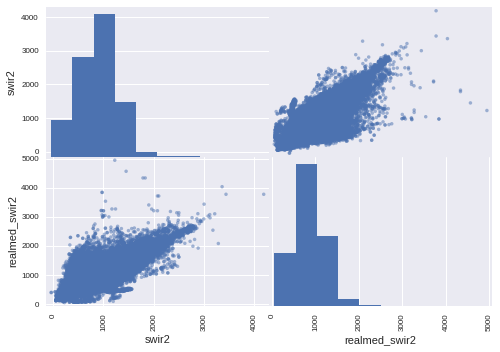

In [185]:
_ = pd.plotting.scatter_matrix(no_changes[['swir2', 'realmed_swir2']], marker='.')

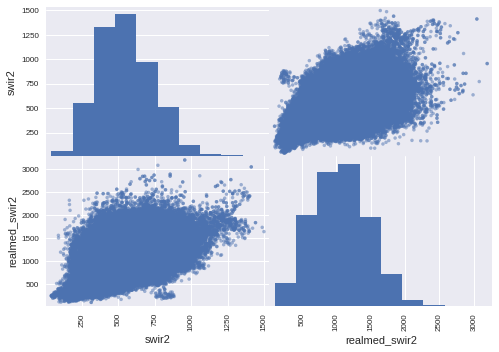

In [186]:
_ = pd.plotting.scatter_matrix(changes[['swir2', 'realmed_swir2']], marker='.')

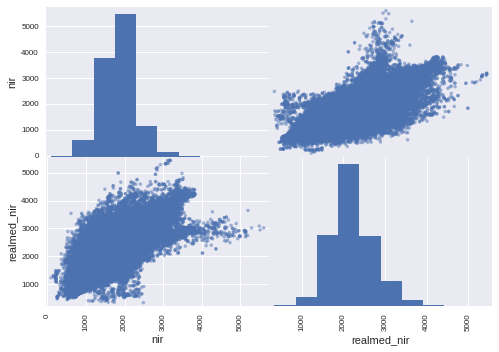

In [187]:
_ = pd.plotting.scatter_matrix(no_changes[['nir', 'realmed_nir']], marker='.')

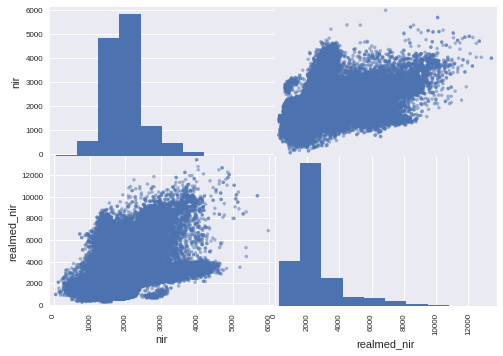

In [188]:
_ = pd.plotting.scatter_matrix(changes[['nir', 'realmed_nir']], marker='.')

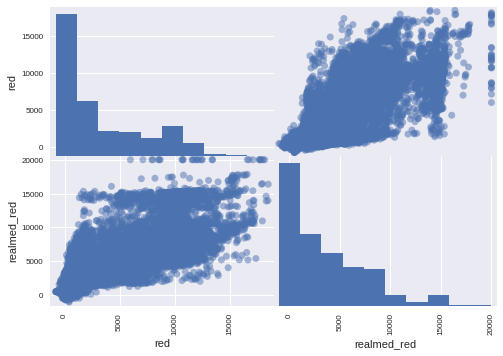

In [189]:
_ = pd.plotting.scatter_matrix(df[['red', 'realmed_red']], marker='o')

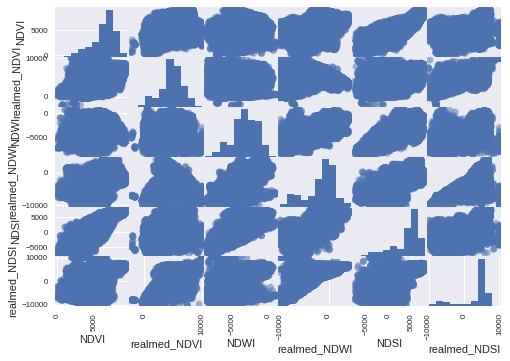

In [190]:
_ = pd.plotting.scatter_matrix(changes[['NDVI', 'realmed_NDVI', 'NDWI', 'realmed_NDWI', 'NDSI', 'realmed_NDSI']], marker='o')

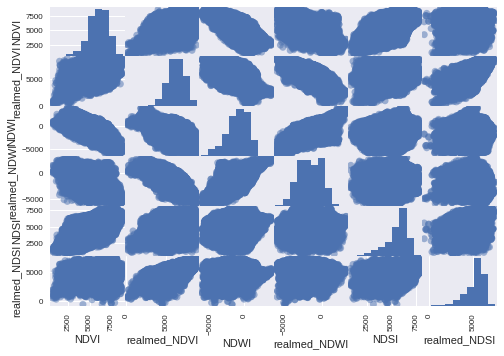

In [191]:
_ = pd.plotting.scatter_matrix(no_changes[['NDVI', 'realmed_NDVI', 'NDWI', 'realmed_NDWI', 'NDSI', 'realmed_NDSI']], marker='o')

In [0]:
# Все завязано на конкретный формат файла. При необходимости - менять функцию
def prepare_data(data):
    # ['system:index', 'name', 'date', 'tree_canopy_cover', 'swir2', 'swir1', 'nir', 'red', 'green', 'blue', 'NDVI', 'NDSI', 'NDWI', 'realmed_swir2', 'realmed_swir1', 'realmed_nir', 'realmed_red', 'realmed_green', 'realmed_blue', 'realmed_NDVI', 'realmed_NDSI', 'realmed_NDWI']

    
    bands = [
        'swir2', 'swir1', 'nir', 'red', 'green', 'blue',
        'realmed_swir2', 'realmed_swir1', 'realmed_nir', 'realmed_red', 'realmed_green', 'realmed_blue'
    ]
    
    indices = [
        'NDVI', 'NDSI', 'NDWI', 
        'realmed_NDVI', 'realmed_NDSI', 'realmed_NDWI'
    ]
    
    inputs = bands + indices
    
    for band in inputs:
      data[band] = data[band]/10000.0

    # fix wrong band values
    for b in bands:
        data.loc[data[b] < 0, b] = 0.0
        data.loc[data[b] > 1, b] = 1.0 
    
    data['tree_canopy_cover'] = data['tree_canopy_cover'] / 100.0
    
    # В system:index содержится ID полигона (у нас много точек на полигон), чтобы избежать оптимистичной оценки из-за автокорреляции
    # выделим номер полигона и сохраним
    data['system:index'] = data['system:index'].str.extract(r'(.+)_\d+$')
    
    data['change'] = (data['name'] == 'Change').astype(int)

    
    addons = ['system:index', 'tree_canopy_cover', 'change']
    # addons = ['system:index', 'change']
        
    # names = set(inputs) - set(['name'])
    names = inputs + addons
    print(names)
    return data[names]
  



In [11]:
train_data = prepare_data(df_train.copy())
test_data = prepare_data(df_test.copy())

train_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


['swir2', 'swir1', 'nir', 'red', 'green', 'blue', 'realmed_swir2', 'realmed_swir1', 'realmed_nir', 'realmed_red', 'realmed_green', 'realmed_blue', 'NDVI', 'NDSI', 'NDWI', 'realmed_NDVI', 'realmed_NDSI', 'realmed_NDWI', 'system:index', 'tree_canopy_cover', 'change']
['swir2', 'swir1', 'nir', 'red', 'green', 'blue', 'realmed_swir2', 'realmed_swir1', 'realmed_nir', 'realmed_red', 'realmed_green', 'realmed_blue', 'NDVI', 'NDSI', 'NDWI', 'realmed_NDVI', 'realmed_NDSI', 'realmed_NDWI', 'system:index', 'tree_canopy_cover', 'change']


,swir2,swir1,nir,red,green,blue,realmed_swir2,realmed_swir1,realmed_nir,realmed_red,...,realmed_blue,NDVI,NDSI,NDWI,realmed_NDVI,realmed_NDSI,realmed_NDWI,system:index,tree_canopy_cover,change
0,0.0812,0.0928,0.1864,0.1405,0.1354,0.1433,0.1188,0.1177,0.7141,0.6909,...,0.6369,0.1820,-0.1305,-0.2971,0.0182,-0.7040,-0.7143,1_0000c7973be77c1b3b27_1_0000c7973be77c1b3b27,0.58,1
1,0.0768,0.0893,0.1521,0.0929,0.0934,0.0974,0.1065,0.1073,0.6690,0.6444,...,0.6148,0.3314,0.1222,-0.2217,0.0199,-0.7109,-0.7218,1_0000c7973be77c1b3b27_1_0000c7973be77c1b3b27,0.60,1
2,0.0768,0.0893,0.1521,0.0929,0.0934,0.0974,0.1065,0.1073,0.6690,0.6444,...,0.6148,0.3314,0.1222,-0.2217,0.0199,-0.7109,-0.7218,1_0000c7973be77c1b3b27_1_0000c7973be77c1b3b27,0.60,1
3,0.0701,0.0824,0.1497,0.0845,0.0900,0.0904,0.0940,0.0965,0.6001,0.5904,...,0.5851,0.3600,0.1099,-0.2627,0.0086,-0.7180,-0.7233,1_0000c7973be77c1b3b27_1_0000c7973be77c1b3b27,0.62,1
4,0.0688,0.0839,0.1524,0.0957,0.0989,0.1067,0.0831,0.0771,0.5414,0.5469,...,0.5533,0.2690,-0.0198,-0.2807,-0.0045,-0.7517,-0.7510,1_0000c7973be77c1b3b27_1_0000c7973be77c1b3b27,0.59,1


In [0]:
def split_data(data, train_val_test=0.66, group='system:index'):
  np.random.seed(1)
  ids = set(data[group])
  count = len(ids)
  print('Found %s unique areas' % (count))

  train_count = int(count * train_val_test)
  
  train = np.random.choice(list(ids), train_count, False)

  val_ids = ids.difference(set(train))
  val = np.array(list(val_ids))
  
  train = data[data[group].isin(train)]
  val = data[data[group].isin(val)]
  
  train = np.array(train.drop(labels=[group], axis=1))
  val = np.array(val.drop(labels=[group], axis=1))

  return train, val
  

In [0]:
def get_batch(data, size, input_count):
    batch = data[np.random.randint(data.shape[0], size=size), :]

    # add a little of noise
    errors = np.random.uniform(low=-0.0001, high=0.0001, size=(size, input_count))
    x = batch[:, :input_count]
    x += + errors
    

    y = batch[:, input_count:]
    
    return x, y
 

In [0]:
def print_model(x_test, y_test):
    model_dir = '.'
    result_filename_prefix = 'res_'
    
    """   
    inference_graph = tf.Graph()
    with tf.Session(graph=inference_graph) as sess:
        loader = tf.train.import_meta_graph(os.path.join(model_dir, model_name+".meta"))
        loader.restore(sess, os.path.join(model_dir, model_name))

        # x = tf.placeholder(tf.float32, [None, input_count])
        # y_ = tf.placeholder(tf.int32, [None, out_count])

        _loss = inference_graph.get_tensor_by_name('loss:0')
        _loss1 = inference_graph.get_tensor_by_name('loss1:0')
        _x = inference_graph.get_tensor_by_name('input:0')
        _y = inference_graph.get_tensor_by_name('target:0')

        _W1 = inference_graph.get_tensor_by_name('weights/w1:0')
        _W2 = inference_graph.get_tensor_by_name('weights/w2:0')
        _W3 = inference_graph.get_tensor_by_name('weights/w3:0')

        _b1 = inference_graph.get_tensor_by_name('biases/b1:0')
        _b2 = inference_graph.get_tensor_by_name('biases/b2:0')
        _b3 = inference_graph.get_tensor_by_name('biases/b3:0')



        print('test ACC:\t', sess.run(_loss, feed_dict={_x: x_test,_y: y_test}))
        print('test ACC1:\t', sess.run(_loss1, feed_dict={_x: x_test,_y: y_test}))
    """
    
    print('test ACC:\t', sess.run(loss, feed_dict={x: x_test, y_: y_test}))
    print('test ACC1:\t', sess.run(loss1, feed_dict={x: x_test, y_: y_test}))

    bestW1, bestW2, bestW3, bestB1, bestB2, bestB3 = sess.run([W1, W2, W3, b1, b2, b3])

    os.makedirs(model_dir, exist_ok=True)
    np.savetxt(os.path.join(model_dir, result_filename_prefix+'w1.txt'), bestW1, delimiter=', ', newline='],\n[', header='[\n', footer='', comments='')
    np.savetxt(os.path.join(model_dir, result_filename_prefix+'b1.txt'), bestB1, delimiter=', ', newline=',\n', header='[\n', footer=']', comments='')

    np.savetxt(os.path.join(model_dir, result_filename_prefix+'w2.txt'), bestW2, delimiter=', ', newline='],\n[', header='[\n[', footer=']', comments='')
    np.savetxt(os.path.join(model_dir, result_filename_prefix+'b2.txt'), bestB2, delimiter=', ', newline=',\n', header='[\n', footer=']', comments='')

    np.savetxt(os.path.join(model_dir, result_filename_prefix+'w3.txt'), bestW3, delimiter=', ', newline='],\n[', header='[\n[', footer=']', comments='')
    np.savetxt(os.path.join(model_dir, result_filename_prefix+'b3.txt'), bestB3, delimiter=', ', newline=',\n', header='[\n', footer=']', comments='')




In [0]:
def model(x, W1, W2, W3, b1, b2, b3):
    # tf.summary.histogram('w3', W3)
    # tf.summary.histogram('b3', b3)

    l1 = tf.nn.relu(tf.matmul(x, W1) + b1)
    # tf.summary.histogram('l1', l1)

    l2 = tf.nn.relu(tf.matmul(l1, W2) + b2)
    # tf.summary.histogram('l2', l2)

    l3_logits = tf.matmul(l2, W3) + b3
    # tf.summary.histogram('l3_logits', l3_logits)

    return l3_logits

In [16]:
test = np.array(test_data.drop(labels=['system:index'], axis=1))
test = np.float32(test)


train, val = split_data(train_data.copy())

Found 1707 unique areas


In [72]:
layer1 = 15
layer2 = 10

summaries_dir = '.'
model_dir = '.'
max_epoch = 5000


out_count = 1
input_count = train.shape[1] - out_count


x = tf.placeholder(tf.float32, [None, input_count], name='input')

with tf.name_scope('weights'):
    W1 = tf.Variable(tf.truncated_normal([input_count, layer1], stddev=0.5), name='w1')
    W2 = tf.Variable(tf.truncated_normal([layer1, layer2], stddev=0.5), name='w2')
    W3 = tf.Variable(tf.truncated_normal([layer2, out_count], stddev=0.5), name='w3')

with tf.name_scope('biases'):
    b1 = tf.Variable(tf.zeros([layer1]), name='b1')
    b2 = tf.Variable(tf.zeros([layer2]), name='b2')
    b3 = tf.Variable(tf.zeros([out_count]), name='b3')

logits = model(x, W1, W2, W3, b1, b2, b3)
y = tf.sigmoid(logits, name='result')


# Define loss and optimizer
y_ = tf.placeholder(tf.int32, [None, out_count], name='target')

loss1 = tf.reduce_mean(
    tf.losses.absolute_difference(labels=y_, predictions=y), name='loss1')
# tf.summary.scalar('abs_diff', loss1)

reg_w = 0.005
loss = tf.reduce_mean(
    # tf.losses.sparse_softmax_cross_entropy(labels=[y_], logits=[tf.transpose([-logits, logits])]) +
    loss1 + reg_w*(tf.nn.l2_loss(W1)+tf.nn.l2_loss(W2)+tf.nn.l2_loss(W3)),
    name='loss'
)


# tf.summary.scalar('Regularized loss', loss)

optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
optimizer = optimizer.minimize(loss)

saver = tf.train.Saver(max_to_keep=1)


sess = tf.InteractiveSession()

# merged = tf.summary.merge_all()
# train_writer = tf.summary.FileWriter(summaries_dir + '/train', sess.graph)
# test_writer = tf.summary.FileWriter(summaries_dir + '/test')

tf.global_variables_initializer().run()
# Train
best_loss = 9999999999999
for epoch in range(max_epoch):
    batch_xs, batch_ys = get_batch(train, 2**14, input_count)
    
    # print(batch_xs.dtype, batch_xs.shape)
    _, train_loss, train_loss1 = sess.run(
        [optimizer, loss, loss1], feed_dict={x: batch_xs, y_: batch_ys}
    )
    # train_writer.add_summary(summary, epoch)

    # Test trained model
    if epoch % 100 == 99:
        val_loss = sess.run(loss, feed_dict={x: val[:, :input_count], y_: val[:, input_count:]})
        print('EPOCH', epoch+1, '\tVal Loss =', val_loss, 'Loss1: \tval', sess.run(loss1, feed_dict={x: val[:, :input_count], y_: val[:, input_count:]}), '\ttrain', train_loss1)
        # test_writer.add_summary(summary, epoch)

        if val_loss < best_loss:
            best_loss = val_loss

            # saver.save(sess, os.path.join(model_dir, "model"))
          
print('Best val LOSS:', best_loss)
test_loss, test_loss1 = sess.run(
        [loss, loss1], feed_dict={x: test[:, :input_count], y_: test[:, input_count:]})

print('Test Loss1 =', test_loss1, 'Test Loss =', test_loss)

print_model(test[:, :input_count], test[:, input_count:])


y_pred_vec = sess.run(y, feed_dict={x: val[:, :input_count]})
y_pred_vec = (y_pred_vec>0.5).astype(int)
y_true_vec = val[:, input_count:]

conf_mat = confusion_matrix(y_true_vec, y_pred_vec)
print('ConfMatr Val')
print(pd.DataFrame(conf_mat))

print('VAL AUC:',roc_auc_score(y_true_vec, y_pred_vec))


y_pred_vec = sess.run(y, feed_dict={x: test[:, :input_count]})
y_pred_vec = (y_pred_vec>0.5).astype(int)
y_true_vec = test[:, input_count:]

conf_mat = confusion_matrix(y_true_vec, y_pred_vec)
print('ConfMatr Test')
print(pd.DataFrame(conf_mat))

print('Test AUC:', roc_auc_score(y_true_vec, y_pred_vec))




# Random Output for test GEE NNet:
tmp = 2*np.random.uniform(size=19) - 1
print(repr(tmp))

sess.run(y, feed_dict={x: tmp.reshape((-1, 19))})


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


EPOCH 100 	Val Loss = 0.4771862 Loss1: 	val 0.30863866 	train 0.36167994
EPOCH 200 	Val Loss = 0.4035697 Loss1: 	val 0.27182585 	train 0.3244177
EPOCH 300 	Val Loss = 0.32464477 Loss1: 	val 0.21026221 	train 0.24542235
EPOCH 400 	Val Loss = 0.2591601 Loss1: 	val 0.15089439 	train 0.16954233
EPOCH 500 	Val Loss = 0.22976586 Loss1: 	val 0.12600219 	train 0.1310235
EPOCH 600 	Val Loss = 0.21365055 Loss1: 	val 0.11587237 	train 0.120602265
EPOCH 700 	Val Loss = 0.20228186 Loss1: 	val 0.1101855 	train 0.11030096
EPOCH 800 	Val Loss = 0.19413325 Loss1: 	val 0.106312454 	train 0.11106998
EPOCH 900 	Val Loss = 0.18838209 Loss1: 	val 0.10368722 	train 0.10283297
EPOCH 1000 	Val Loss = 0.18417044 Loss1: 	val 0.10164967 	train 0.10417764
EPOCH 1100 	Val Loss = 0.18114206 Loss1: 	val 0.10007403 	train 0.09991166
EPOCH 1200 	Val Loss = 0.17888416 Loss1: 	val 0.098849595 	train 0.10277464
EPOCH 1300 	Val Loss = 0.17747 Loss1: 	val 0.09807531 	train 0.09852642
EPOCH 1400 	Val Loss = 0.17627811 Loss1:

ConfMatr Val
       0      1
0  82920   3102
1   5900  38927
VAL AUC: 0.916161175792984
ConfMatr Test
        0      1
0  105251   4119
1    4082  49907
Test AUC: 0.9433654277774723
array([ 0.58140911,  0.91633651, -0.95124248,  0.72766197, -0.37404587,
       -0.19249674, -0.96542502,  0.28883898, -0.29350939, -0.51591441,
       -0.58225105, -0.52458952,  0.0888801 ,  0.39729974, -0.89633258,
       -0.67868836,  0.73925801, -0.57060408, -0.08550733])


array([[0.00021267]], dtype=float32)

In [68]:
print('Test AUC:',roc_auc_score(y_true_vec, y_pred_vec))

Test AUC: 0.9430524766665489


In [0]:
files.download("res_b1.txt") 
files.download("res_b2.txt") 
files.download("res_b3.txt") 

files.download("res_w1.txt") 
files.download("res_w2.txt") 
files.download("res_w3.txt") 


In [50]:
tmp = 2*np.random.uniform(size=19)-0.9
print(repr(tmp))

sess.run(y, feed_dict={x: tmp.reshape((-1, 19))})

array([-0.31765341,  0.92801987, -0.64239067, -0.73062897,  1.02611307,
        0.02976738,  1.04609416,  0.30796901,  1.06413099,  0.45610053,
        0.52267034,  0.07851114,  0.7031144 ,  0.73078295,  0.46104055,
        0.12061064,  0.6390835 ,  0.2535262 , -0.59780119])


array([[0.00387118]], dtype=float32)